<a href="https://colab.research.google.com/github/EugenHotaj/pytorch-generative/blob/master/notebooks/__draft__bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from torch import distributions
from scipy import linalg, spatial

In [83]:
def sausage_plot(X, Y=None, mu_sig=None, fn=None, obs=None):
    """Creates a sausage plot of a 1D Gaussian process. 

    Args:
        X: (n x 1) array containing the x-axis coordinates.
        Y: (n x k) array containing k samples drawn from the Gaussian process at X.
        mu_sig: Tuple of (n x 1) arrays containing the marginal (means, stds) at X. If
            provided the means and 95% credible intervals are plotted.
        fn: True (noiseless) function being modeled by the Gaussian process. If 
            provided, fn(X) is plotted.
        obs: Tuple of (possibly noisy) observations from the true function.
    """
    assert any([Y is not None, mu_sig is not None, fn is not None])

    fig = plt.figure(figsize=(20, 4))
    y_max = []
 
    # Plot samples.
    if Y is not None:
        for i in range(Y.shape[0]): 
            sample = Y[i, :]
            plt.plot(X, sample, color="tab:orange")
            y_max.append(sample)

    # Plot mean and credible intervals.
    if mu_sig is not None:
        mu, sigma = mu_sig
        lower_bound, upper_bound = mu - 1.96 * sigma, mu + 1.96 * sigma
        plt.fill_between(X, lower_bound, upper_bound, facecolor='lightblue')
        plt.plot(X, mu, c="tab:blue")
        y_max.extend([lower_bound, upper_bound, mu])

    # Plot the true function.
    if fn is not None:
        Y = fn(X)
        plt.plot(X, Y, color="tab:red", linestyle="dashed")
        y_max.append(Y)

    # Plot observations.
    if obs is not None:
        obs_x, obs_y = obs
        plt.scatter(obs_x[:-1], obs_y[:-1], color="tab:red", marker="x", s=128)
        plt.scatter(obs_x[-1], obs_y[-1], color="tab:green", marker="x", s=128)
        y_max.append(obs_y)

    # Set axis limits.
    plt.xlim(X.min(), X.max())
    y_max = max([np.abs(y).max() for y in y_max])
    plt.ylim(-y_max - .5, y_max + .5)

### Gaussian Processes

In [84]:
class SquaredExponential(nn.Module):
    def __init__(self, std=None, lengthscale=None):
        super().__init__()
        self.std = std or torch.tensor(1.0)
        self.lengthscale = lengthscale or torch.tensor(1.0)

    def __call__(self, left, right):
        d = torch.cdist(left, right) / self.lengthscale
        return self.std**2 * torch.exp(-.5 * d**2)

class Const(nn.Module):
    def __init__(self, value=None):
        super().__init__()
        self.value = value or torch.tensor(0.0)

    def __call__(self, x):
        return torch.ones_like(x) * self.value


class GaussianProcess(nn.Module):

    def __init__(self, mean, kernel, noise_var=0.0):
        super().__init__()
        self.mean = mean
        self.kernel = kernel
        self.noise_var = noise_var
        self.train_x = None
        self.train_y = None

    def fit(self, x, y):
        if self.train_x is None:
            self.train_x , self.train_y = x, y
        else:
            self.train_x = torch.cat([self.train_x, x])
            self.train_y = torch.cat([self.train_y, y])
    
    def predict(self, x):
        if self.train_x is None:
            return self.mean(x), self.kernel(x, x)

        # Compute means and covariances.
        train_mu, x_mu = self.mean(self.train_x), self.mean(x)
        train_sig = (
            self.kernel(self.train_x, self.train_x) + 
            self.noise_var * torch.eye(self.train_x.shape[0])
        )
        x_sig, cross_sig = self.kernel(x, x), self.kernel(self.train_x, x)

       # Compute posterior mean and covariance.
        solved = torch.linalg.solve(train_sig, cross_sig).T 
        mu = x_mu + solved @ (self.train_y - train_mu)
        sig = x_sig - (solved @ cross_sig)
        
        return mu, sig

    # TODO(eugenhotaj): Figure out why PyTorch claims the covariance matrix is not
    # positive semidefinite.
    def sample(self, x, n_samples=1):
        with torch.no_grad():
            mu, sig = self.predict(x)
            mu, sig = mu.numpy(), sig.numpy()
        sample = np.random.multivariate_normal(mu.squeeze(), sig, size=(n_samples,))
        return torch.tensor(sample)

In [85]:
domain = 0, 6
n_grid = 100
n_train = 5
n_samples = 4
noise_std = 0.1

def f(x, noise=0.):
    y = torch.sin(x) 
    if noise:
        y += torch.randn(size=x.shape) * noise
    return y

grid_x = torch.linspace(domain[0], domain[1], n_grid, dtype=torch.float64)
train_x = torch.rand(n_train, 1, dtype=torch.float64) * domain[1]
train_y = f(train_x, noise_std)

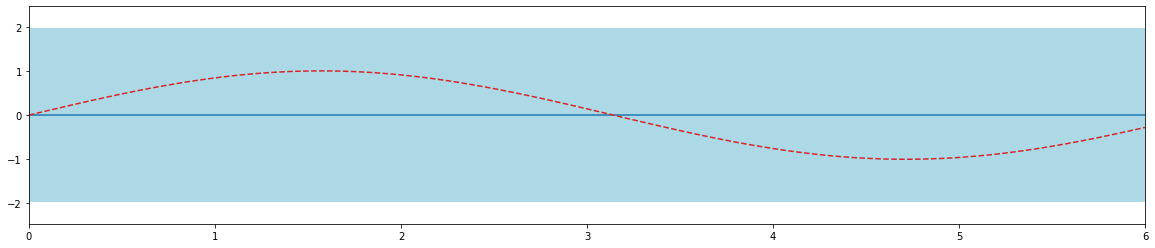

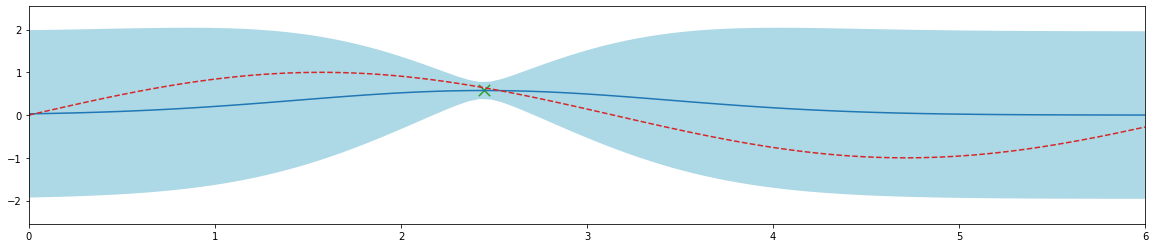

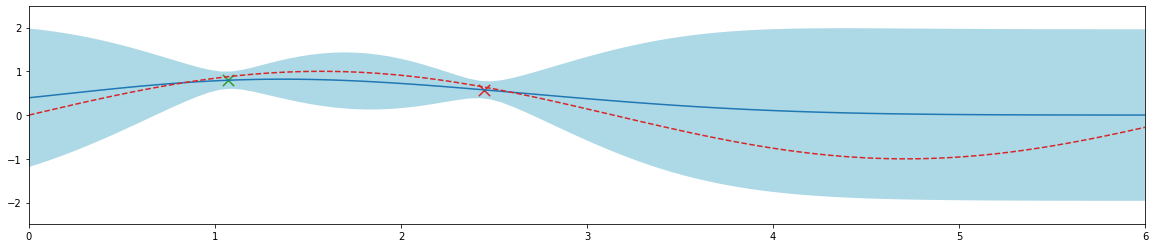

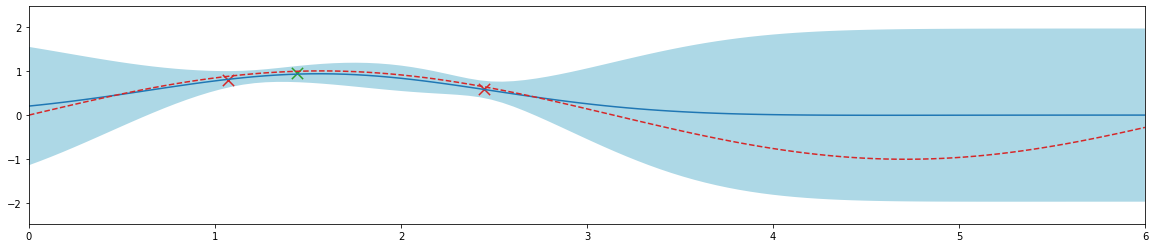

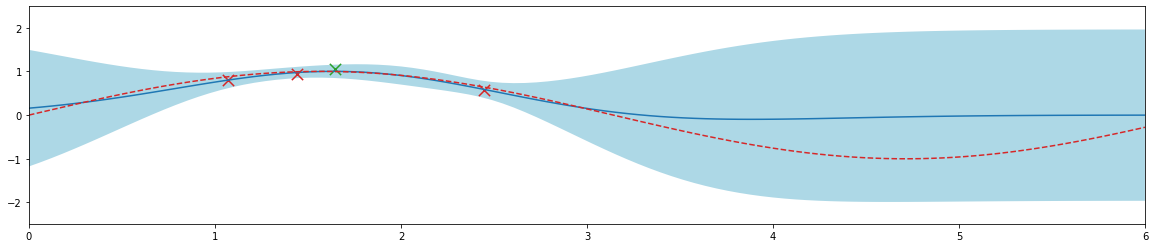

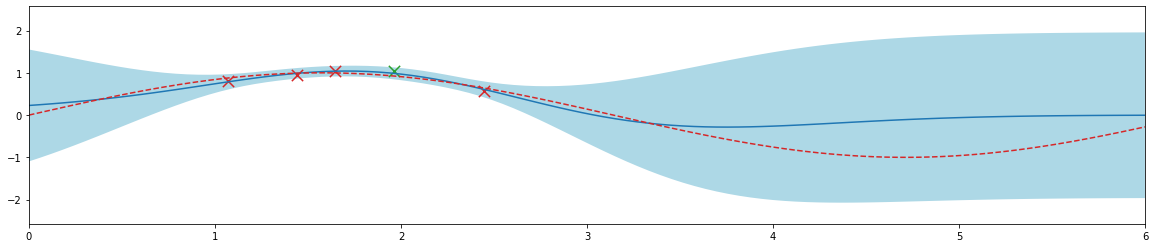

In [86]:
gp = GaussianProcess(Const(), SquaredExponential(), noise_std**2)

# Sample from prior.
mu, sigma = gp.predict(grid_x.reshape(-1, 1))
sausage_plot(grid_x, None, (mu.squeeze(), torch.sqrt(torch.diag(sigma))), f)

# Sample from posterior.
for i in range(len(train_x)):
    gp.fit(train_x[i:i+1], train_y[i:i+1])
    mu, sigma = gp.predict(grid_x.reshape(-1, 1))
    sausage_plot(
        grid_x, 
        None, 
        (mu.squeeze(), np.sqrt(np.diag(sigma))), 
        f, 
        (train_x[:(i+1)], train_y[:(i+1)]),
    )

### Bayeisan Optimization via Thompson Sampling 

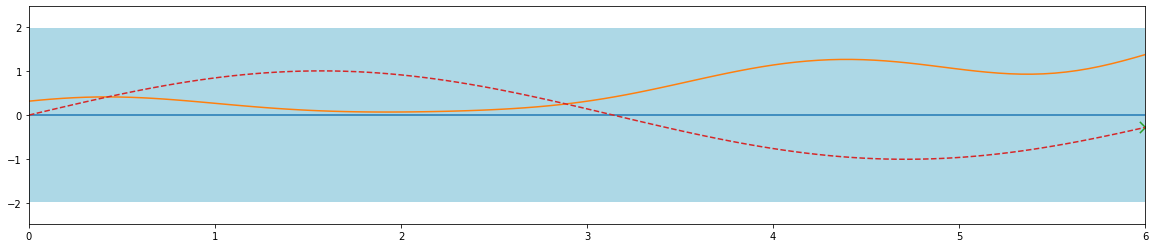

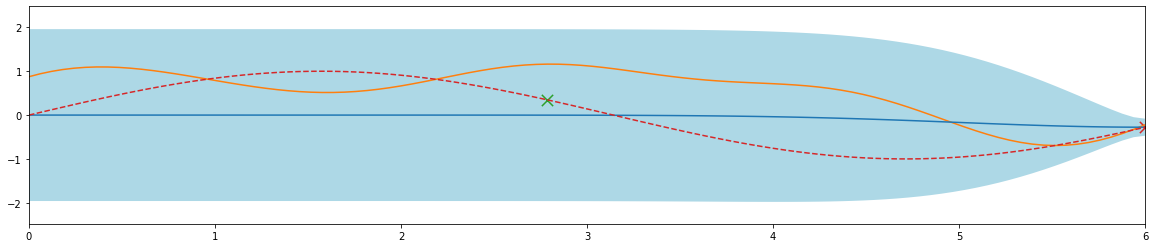

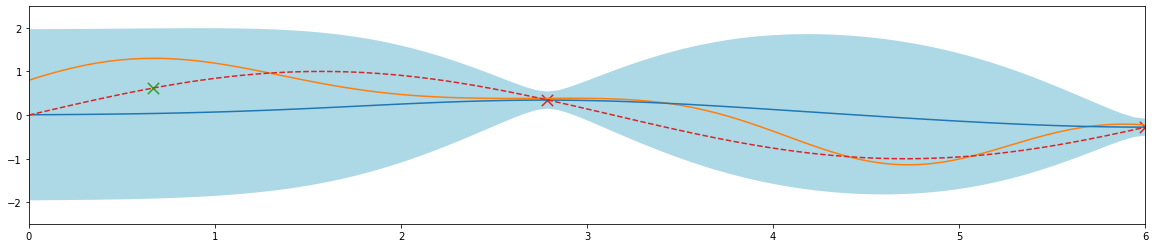

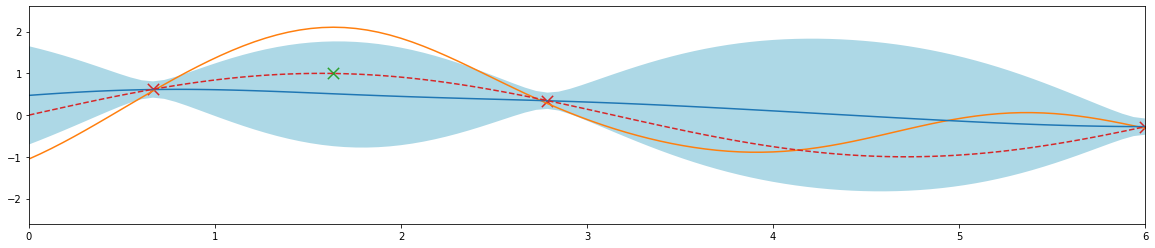

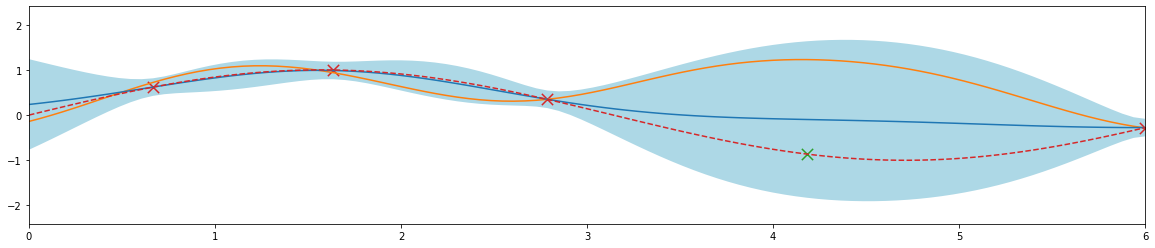

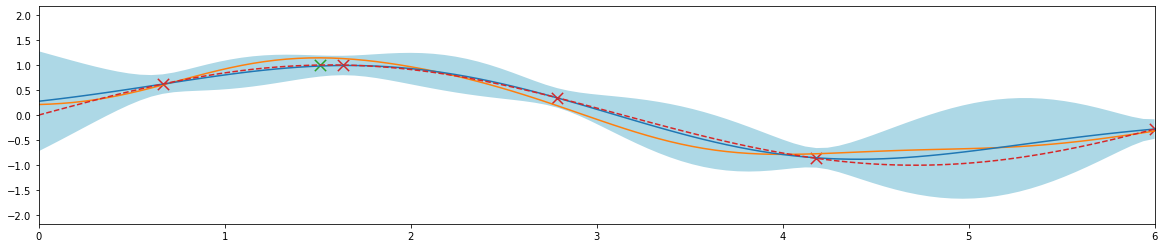

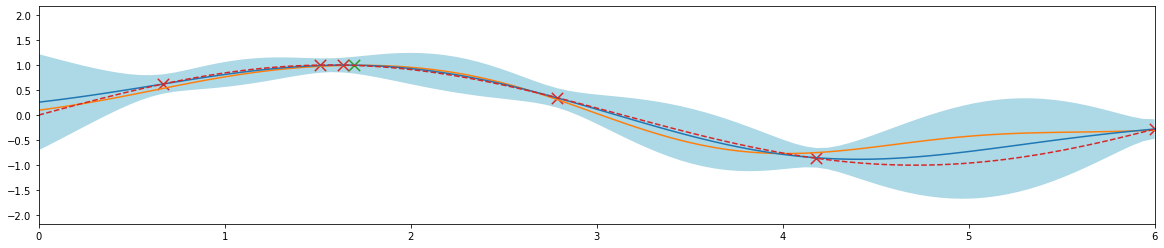

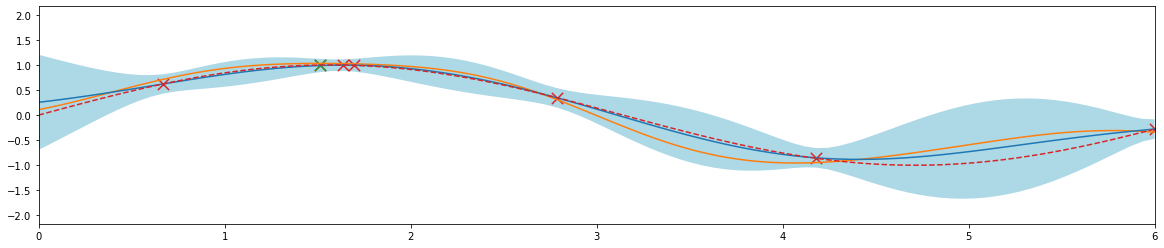

In [87]:
train_x, train_y = [], []
gp = GaussianProcess(Const(), SquaredExponential(), noise_std**2)
for i in range(8):
    # Get Thompson sample and maximize.
    mu, sigma, = gp.predict(grid_x.reshape(-1, 1))
    sample = gp.sample(grid_x.reshape(-1, 1))
    max_idx = torch.argmax(sample)
    max_x = grid_x[max_idx.item()]
    max_y = f(max_x)

    # Fit GP for next round.
    train_x.append(max_x)
    train_y.append(max_y)
    gp.fit(max_x.view(-1, 1), max_y.view(-1, 1))

    # Plot round.
    sausage_plot(grid_x, sample, (mu.squeeze(), np.sqrt(np.diag(sigma))), f, (train_x, train_y))